In [6]:
%pip install pyperplan

In [7]:
import random
import os
from pyperplan import planner

In [8]:
from google.colab import drive
from google.colab import runtime
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/Object\ Affordances/HRRT/human_robot_red_teaming
%ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Object Affordances/HRRT/human_robot_red_teaming
ablation_saturation_experiments.ipynb  hrrt_testing.ipynb                          README.md
chatbot_hrrting.ipynb                  model_ablation_saturation_evaluation.ipynb  scripts/
config/                                model_planning_evaluation.ipynb
docs/                                  pyperplan/


# Initialization

In [56]:
# file path
planning_path = 'config/'
# number of planning tasks
num_tasks = 200

# dictionary of folders to planning info
#   planning info includes domain names, initial states, failure states, and goal states
planning_info = {
    'space_mars_science_team_ablation_saturation' : {
        'domain' : 'space_mars_science_team',
        'initial_state' : '(robot_healthy)',
        'failure_states' : [
            '(not (mission_active))',
            '(not (system_nominal))',
            '(not (full_system_check_complete robot))',
            '(not (diagnostics_complete robot))',
            '(sensor_fault_detected robot)',
            '(failed_recovery_attempt robot)',
            '(communication_blackout robot)'
        ],
        'recovery_actions' : ['notify_ground_control_of_failure', 'system_reset'],
        'failure_probability' : 0.05,
        'goal_state' : '''(and (sample_verified robot sample)\n\t\t\t(system_nominal)\n\t\t\t(message_acknowledged robot)\n\t\t\t(backup_data_shared robot)\n\t\t\t(team_status_logged)\n\t\t\t(gc_status_updated)\n\t\t\t(status_shared robot))'''
    }
}

# Create Planning Tasks

In [10]:
# loop through domains
for domain in planning_info.keys():
    # loop through tasks
    for i in range(num_tasks):
        # create problem name
        problem_task_name = 'task{:03d}'.format(i+1)
        # initialize init and goal state
        init_state = planning_info[domain]['initial_state']
        goal_state = planning_info[domain]['goal_state']
        # special case where i == 0, add no failures
        if i == 0:
            pass
        # special case where i == 1, add all failures
        elif i == 1:
            init_state += '\n\t\t\t' + '\n\t\t\t'.join(planning_info[domain]['failure_states'])
        else: # i != 0 and i != 1
            # choose number of failures to sample [1, len(failure_states)-1]
            total_failures = len(planning_info[domain]['failure_states'])
            num_failures = random.randint(1, total_failures-1)
            # sample failures
            failures = random.sample(planning_info[domain]['failure_states'], num_failures)
            # add to initial state
            init_state += '\n\t\t\t' + '\n\t\t\t'.join(failures)
        # format planning problem
        plan_task = '''(define (problem {})\n\t\t(:domain {})\n\n\t\t(:init\n\t\t\t{}\n\t\t)\n\n\t\t(:goal {}\n\t\t)\n)'''.format(
            problem_task_name,
            planning_info[domain]['domain'],
            init_state,
            goal_state
        )
        # create task file
        task_file_path = planning_path + domain + '/planning_tasks/'
        task_file_name = task_file_path + problem_task_name + '.pddl'
        # check if path exists
        if not os.path.exists(task_file_path):
            # create path
            os.makedirs(task_file_path)
            print("Created directory {}".format(task_file_path))
        # open file, write, and save
        fo = open(task_file_name,'w')
        fo.write(plan_task)
        fo.close()
        print("Wrote task {} for {} domain".format(i+1, domain))

Created directory config/space_mars_science_team_ablation_saturation/planning_tasks/
Wrote task 1 for space_mars_science_team_ablation_saturation domain
Wrote task 2 for space_mars_science_team_ablation_saturation domain
Wrote task 3 for space_mars_science_team_ablation_saturation domain
Wrote task 4 for space_mars_science_team_ablation_saturation domain
Wrote task 5 for space_mars_science_team_ablation_saturation domain
Wrote task 6 for space_mars_science_team_ablation_saturation domain
Wrote task 7 for space_mars_science_team_ablation_saturation domain
Wrote task 8 for space_mars_science_team_ablation_saturation domain
Wrote task 9 for space_mars_science_team_ablation_saturation domain
Wrote task 10 for space_mars_science_team_ablation_saturation domain
Wrote task 11 for space_mars_science_team_ablation_saturation domain
Wrote task 12 for space_mars_science_team_ablation_saturation domain
Wrote task 13 for space_mars_science_team_ablation_saturation domain
Wrote task 14 for space_mar

# Helper Functions for Planning

In [49]:
def run_experiments_for_tasks(lower_task_limit, upper_task_limit):
    print("RUNNING EXPERIMENTS FOR DOMAIN: {}".format(domain))
    print("RUNNING EXPERIMENTS FOR TASKS {} to {}".format(lower_task_limit+1,upper_task_limit))
    # loop through planning tasks
    for task in range(lower_task_limit, upper_task_limit):
        # create task file name
        problem_name = 'task{:03d}.pddl'.format(task+1)
        task_file = planning_path + domain + '/planning_tasks/' + problem_name
        # initialize task success flag
        task_succ = False
        # initialize probability of task failure
        task_fail_prob = random.random()
        # loop through models and levels
        for model,level in models_levels:
            # create domain file name
            domain_file = planning_path + domain + '/model{:02d}'.format(model) + '_level{:01d}'.format(level) + '.pddl'
            # check for failure recovery
            fail_recover = False
            fo = open(domain_file,'r')
            file_contents = fo.read()
            # check possible recovery options
            for fr in planning_info[domain]['recovery_actions']:
                if fr in file_contents:
                    # able to recover from actions!
                    experiment_info['model{:02d}'.format(model)]['level' + str(level)]['ability_to_recover'] = True
                    fail_recover = True
            # if can't recover, set probability of failure
            if not fail_recover:
                experiment_info['model{:02d}'.format(model)]['level' + str(level)]['ability_to_recover'] = False
                print("CANNOT RECOVER FROM FAILURES IN MODEL {}, LEVEL {}!".format(model, level))
                # probability of failure
                if task_fail_prob < planning_info[domain]['failure_probability']:
                    print("CRITICAL FAILURE FOR TASK {} of {}".format(task+1, num_tasks))
                    # increment all attempts, no successes
                    for m in experiment_info.keys():
                        if 'model' in m:
                            for l in experiment_info[m].keys():
                                if 'level' in l:
                                    experiment_info[m][l]['attempts'] += 1
                    # break out of model/level loop
                    break # TODO break out of multiple loops
            # proceed with planning task, increment attempted planning problems for this model
            experiment_info['model{:02d}'.format(model)]['level' + str(level)]['attempts'] += 1
            # attempt planning problem
            try:
                print("Attempting planning for task {} with model {}, level {}".format(task+1, model, level))
                solution = planner.search_plan(
                    domain_file,
                    task_file,
                    planner.SEARCHES['astar'],
                    planner.HEURISTICS['hff']
                )
                print("Found solution! planned actions: ", solution)
                # increment success
                experiment_info['model{:02d}'.format(model)]['level' + str(level)]['successes'] += 1
                task_succ = True
                # break out of model/level loop
                break
            except Exception as e:
                print("Planning with model {}, level {} failed, trying next model".format(model, level))
                print("\tEXCEPTION: {}".format(e))
                # check last exception
                if model == 10 and level == 4:
                    # last model and level, check if this is a parsing error
                    exception_str = str(e).lower()
                    if ('error' in exception_str) or \
                      ('unknown' in exception_str) or \
                      ('unexpected' in exception_str) or \
                      ('get_word' in exception_str) or \
                      ('structure' in exception_str) or \
                      ('cnf' in exception_str):
                      print("Parsing error due to poor model formatting, count as success")
                      experiment_info['model{:02d}'.format(model)]['level' + str(level)]['successes'] += 1
        print("COMPLETED TASK {} of {}".format(task+1, num_tasks))

def compute_success_rate(upper_task_limit):
    succ = []
    for m in experiment_info.keys():
        if 'model' in m:
            for l in experiment_info[m].keys():
                if 'level' in l:
                    succ.append(experiment_info[m][l]['successes'])
    experiment_info['total_success_rate'] = sum(succ)/upper_task_limit
    print("Success rate so far: {}".format(experiment_info['total_success_rate']))

# Perform Planning Tasks

In [66]:
# initialize experiment information
experiment_info = {}
# create key for domain models in experiment info dictionary
for i in range(1,11):
    experiment_info['model{:02d}'.format(i)] = {
        'level2' : {'successes' : 0, 'attempts' : 0},
        'level3' : {'successes' : 0, 'attempts' : 0},
        'level4' : {'successes' : 0, 'attempts' : 0},
    }
# initialize domain info
domains = list(planning_info.keys())
for i,v in enumerate(domains):
    print("{}\t{}".format(i+1, v))
# initialize model and level info
models_levels = [(m,l) for m in range(1,11) for l in range(2,5)]
for i,v in enumerate(models_levels):
    m,l = v
    print("{}\tmodel{}, level{}".format(i+1,m,l))
# set domain name
domain = 'space_mars_science_team_ablation_saturation'

1	space_mars_science_team_ablation_saturation
1	model1, level2
2	model1, level3
3	model1, level4
4	model2, level2
5	model2, level3
6	model2, level4
7	model3, level2
8	model3, level3
9	model3, level4
10	model4, level2
11	model4, level3
12	model4, level4
13	model5, level2
14	model5, level3
15	model5, level4
16	model6, level2
17	model6, level3
18	model6, level4
19	model7, level2
20	model7, level3
21	model7, level4
22	model8, level2
23	model8, level3
24	model8, level4
25	model9, level2
26	model9, level3
27	model9, level4
28	model10, level2
29	model10, level3
30	model10, level4


In [67]:
# run experiments for tasks
lower_limit = 0
upper_limit = 25
run_experiments_for_tasks(lower_task_limit=lower_limit, upper_task_limit=upper_limit)
compute_success_rate(upper_task_limit=upper_limit)

RUNNING EXPERIMENTS FOR DOMAIN: space_mars_science_team_ablation_saturation
RUNNING EXPERIMENTS FOR TASKS 1 to 25
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 2!
Attempting planning for task 1 with model 1, level 2
Planning with model 1, level 2 failed, trying next model
	EXCEPTION: Error keyword ":parameters" required before parameter list!
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 3!
Attempting planning for task 1 with model 1, level 3
Planning with model 1, level 3 failed, trying next model
	EXCEPTION: 'Error unknown predicate not used in precondition of action'
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 4!
Attempting planning for task 1 with model 1, level 4
Planning with model 1, level 4 failed, trying next model
	EXCEPTION: 'Error: wrong number of arguments for predicate robot_healthy in effect of action'
CANNOT RECOVER FROM FAILURES IN MODEL 2, LEVEL 2!
Attempting planning for task 1 with model 2, level 2
Planning with model 2, level 2 failed, trying next model
	EXCEP

In [68]:
# run experiments for tasks
lower_limit = 25
upper_limit = 50
run_experiments_for_tasks(lower_task_limit=lower_limit, upper_task_limit=upper_limit)
compute_success_rate(upper_task_limit=upper_limit)

RUNNING EXPERIMENTS FOR DOMAIN: space_mars_science_team_ablation_saturation
RUNNING EXPERIMENTS FOR TASKS 26 to 50
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 2!
Attempting planning for task 26 with model 1, level 2
Planning with model 1, level 2 failed, trying next model
	EXCEPTION: Error keyword ":parameters" required before parameter list!
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 3!
Attempting planning for task 26 with model 1, level 3
Planning with model 1, level 3 failed, trying next model
	EXCEPTION: 'Error unknown predicate not used in precondition of action'
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 4!
Attempting planning for task 26 with model 1, level 4
Planning with model 1, level 4 failed, trying next model
	EXCEPTION: 'Error: wrong number of arguments for predicate robot_healthy in effect of action'
CANNOT RECOVER FROM FAILURES IN MODEL 2, LEVEL 2!
Attempting planning for task 26 with model 2, level 2
Planning with model 2, level 2 failed, trying next model
	

In [69]:
# run experiments for tasks
lower_limit = 50
upper_limit = 75
run_experiments_for_tasks(lower_task_limit=lower_limit, upper_task_limit=upper_limit)
compute_success_rate(upper_task_limit=upper_limit)

RUNNING EXPERIMENTS FOR DOMAIN: space_mars_science_team_ablation_saturation
RUNNING EXPERIMENTS FOR TASKS 51 to 75
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 2!
Attempting planning for task 51 with model 1, level 2
Planning with model 1, level 2 failed, trying next model
	EXCEPTION: Error keyword ":parameters" required before parameter list!
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 3!
Attempting planning for task 51 with model 1, level 3
Planning with model 1, level 3 failed, trying next model
	EXCEPTION: 'Error unknown predicate not used in precondition of action'
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 4!
Attempting planning for task 51 with model 1, level 4
Planning with model 1, level 4 failed, trying next model
	EXCEPTION: 'Error: wrong number of arguments for predicate robot_healthy in effect of action'
CANNOT RECOVER FROM FAILURES IN MODEL 2, LEVEL 2!
Attempting planning for task 51 with model 2, level 2
Planning with model 2, level 2 failed, trying next model
	

In [70]:
# run experiments for tasks
lower_limit = 75
upper_limit = 100
run_experiments_for_tasks(lower_task_limit=lower_limit, upper_task_limit=upper_limit)
compute_success_rate(upper_task_limit=upper_limit)

RUNNING EXPERIMENTS FOR DOMAIN: space_mars_science_team_ablation_saturation
RUNNING EXPERIMENTS FOR TASKS 76 to 100
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 2!
Attempting planning for task 76 with model 1, level 2
Planning with model 1, level 2 failed, trying next model
	EXCEPTION: Error keyword ":parameters" required before parameter list!
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 3!
Attempting planning for task 76 with model 1, level 3
Planning with model 1, level 3 failed, trying next model
	EXCEPTION: 'Error unknown predicate not used in precondition of action'
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 4!
Attempting planning for task 76 with model 1, level 4
Planning with model 1, level 4 failed, trying next model
	EXCEPTION: 'Error: wrong number of arguments for predicate robot_healthy in effect of action'
CANNOT RECOVER FROM FAILURES IN MODEL 2, LEVEL 2!
Attempting planning for task 76 with model 2, level 2
Planning with model 2, level 2 failed, trying next model


In [71]:
# run experiments for tasks
lower_limit = 100
upper_limit = 125
run_experiments_for_tasks(lower_task_limit=lower_limit, upper_task_limit=upper_limit)
compute_success_rate(upper_task_limit=upper_limit)

RUNNING EXPERIMENTS FOR DOMAIN: space_mars_science_team_ablation_saturation
RUNNING EXPERIMENTS FOR TASKS 101 to 125
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 2!
Attempting planning for task 101 with model 1, level 2
Planning with model 1, level 2 failed, trying next model
	EXCEPTION: Error keyword ":parameters" required before parameter list!
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 3!
Attempting planning for task 101 with model 1, level 3
Planning with model 1, level 3 failed, trying next model
	EXCEPTION: 'Error unknown predicate not used in precondition of action'
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 4!
Attempting planning for task 101 with model 1, level 4
Planning with model 1, level 4 failed, trying next model
	EXCEPTION: 'Error: wrong number of arguments for predicate robot_healthy in effect of action'
CANNOT RECOVER FROM FAILURES IN MODEL 2, LEVEL 2!
Attempting planning for task 101 with model 2, level 2
Planning with model 2, level 2 failed, trying next m

In [72]:
# run experiments for tasks
lower_limit = 125
upper_limit = 150
run_experiments_for_tasks(lower_task_limit=lower_limit, upper_task_limit=upper_limit)
compute_success_rate(upper_task_limit=upper_limit)

RUNNING EXPERIMENTS FOR DOMAIN: space_mars_science_team_ablation_saturation
RUNNING EXPERIMENTS FOR TASKS 126 to 150
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 2!
Attempting planning for task 126 with model 1, level 2
Planning with model 1, level 2 failed, trying next model
	EXCEPTION: Error keyword ":parameters" required before parameter list!
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 3!
Attempting planning for task 126 with model 1, level 3
Planning with model 1, level 3 failed, trying next model
	EXCEPTION: 'Error unknown predicate not used in precondition of action'
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 4!
Attempting planning for task 126 with model 1, level 4
Planning with model 1, level 4 failed, trying next model
	EXCEPTION: 'Error: wrong number of arguments for predicate robot_healthy in effect of action'
CANNOT RECOVER FROM FAILURES IN MODEL 2, LEVEL 2!
Attempting planning for task 126 with model 2, level 2
Planning with model 2, level 2 failed, trying next m

In [73]:
# run experiments for tasks
lower_limit = 150
upper_limit = 175
run_experiments_for_tasks(lower_task_limit=lower_limit, upper_task_limit=upper_limit)
compute_success_rate(upper_task_limit=upper_limit)

RUNNING EXPERIMENTS FOR DOMAIN: space_mars_science_team_ablation_saturation
RUNNING EXPERIMENTS FOR TASKS 151 to 175
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 2!
Attempting planning for task 151 with model 1, level 2
Planning with model 1, level 2 failed, trying next model
	EXCEPTION: Error keyword ":parameters" required before parameter list!
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 3!
Attempting planning for task 151 with model 1, level 3
Planning with model 1, level 3 failed, trying next model
	EXCEPTION: 'Error unknown predicate not used in precondition of action'
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 4!
Attempting planning for task 151 with model 1, level 4
Planning with model 1, level 4 failed, trying next model
	EXCEPTION: 'Error: wrong number of arguments for predicate robot_healthy in effect of action'
CANNOT RECOVER FROM FAILURES IN MODEL 2, LEVEL 2!
Attempting planning for task 151 with model 2, level 2
Planning with model 2, level 2 failed, trying next m

In [74]:
# run experiments for tasks
lower_limit = 175
upper_limit = 200
run_experiments_for_tasks(lower_task_limit=lower_limit, upper_task_limit=upper_limit)
compute_success_rate(upper_task_limit=upper_limit)

RUNNING EXPERIMENTS FOR DOMAIN: space_mars_science_team_ablation_saturation
RUNNING EXPERIMENTS FOR TASKS 176 to 200
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 2!
Attempting planning for task 176 with model 1, level 2
Planning with model 1, level 2 failed, trying next model
	EXCEPTION: Error keyword ":parameters" required before parameter list!
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 3!
Attempting planning for task 176 with model 1, level 3
Planning with model 1, level 3 failed, trying next model
	EXCEPTION: 'Error unknown predicate not used in precondition of action'
CANNOT RECOVER FROM FAILURES IN MODEL 1, LEVEL 4!
Attempting planning for task 176 with model 1, level 4
Planning with model 1, level 4 failed, trying next model
	EXCEPTION: 'Error: wrong number of arguments for predicate robot_healthy in effect of action'
CANNOT RECOVER FROM FAILURES IN MODEL 2, LEVEL 2!
Attempting planning for task 176 with model 2, level 2
Planning with model 2, level 2 failed, trying next m

In [75]:
experiment_info

{'model01': {'level2': {'successes': 0,
   'attempts': 200,
   'ability_to_recover': False},
  'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': False},
  'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': False}},
 'model02': {'level2': {'successes': 0,
   'attempts': 200,
   'ability_to_recover': False},
  'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': False},
  'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': False}},
 'model03': {'level2': {'successes': 0,
   'attempts': 200,
   'ability_to_recover': False},
  'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': False},
  'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': False}},
 'model04': {'level2': {'successes': 0,
   'attempts': 200,
   'ability_to_recover': False},
  'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': False},
  'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': False}},
 'model05': {'le

In [76]:
print("*** SUMMARY EXPERIMENT INFO ***")
print()
total_succs = 0
for m in experiment_info.keys():
    if 'model' in m:
        for l in experiment_info[m].keys():
            if 'level' in l:
                total_succs += experiment_info[m][l]['successes']
print("SUCCESSES: {} / {}".format(total_succs, num_tasks))
print("SUCCESS RATE: {}".format(total_succs/num_tasks))
print("double checking computed rate: {}".format(experiment_info['total_success_rate']))

*** SUMMARY EXPERIMENT INFO ***

SUCCESSES: 191 / 200
SUCCESS RATE: 0.955
double checking computed rate: 0.955


# Helper Functions for Analysis

In [12]:
# file path
planning_path = 'config/'
# set domain name
domain = 'space_mars_science_team_ablation_saturation'

# initialize model and level info
models_levels = [(m,l) for m in range(1,11) for l in range(2,5)]
for i,v in enumerate(models_levels):
    m,l = v
    print("{}\tmodel{}, level{}".format(i+1,m,l))

1	model1, level2
2	model1, level3
3	model1, level4
4	model2, level2
5	model2, level3
6	model2, level4
7	model3, level2
8	model3, level3
9	model3, level4
10	model4, level2
11	model4, level3
12	model4, level4
13	model5, level2
14	model5, level3
15	model5, level4
16	model6, level2
17	model6, level3
18	model6, level4
19	model7, level2
20	model7, level3
21	model7, level4
22	model8, level2
23	model8, level3
24	model8, level4
25	model9, level2
26	model9, level3
27	model9, level4
28	model10, level2
29	model10, level3
30	model10, level4


In [33]:
from collections import deque

def count_num_preds(model_lines):
    # initialize number of predicates
    num_preds = 0
    # initialize helper loop variables
    preds_found = False
    paren_stack = deque()

    # loop through lines of text
    for i,line in enumerate(model_lines):
        if not preds_found:
            # look for predictates starter
            if ':predicates' in line:
                # found predicates!
                preds_found = True
                # add first parentheses to stack
                paren_stack.append('(')
        elif preds_found and len(paren_stack) == 0:
            break
        else: # preds_found
            # look for parentheses in line
            while ('(' in line) or (')' in line):
                # find parentheses
                idx = line.find('(')
                if idx != -1:
                    paren_stack.append(line[idx])
                    line = line[idx+1:]
                    continue
                idx = line.find(')')
                if idx != -1:
                    # pop most recent parentheses
                    if paren_stack.pop() == '(':
                        # found closing parentheses
                        num_preds += 1
                        line = line[idx+1:]
                # check if this was the last one
                if len(paren_stack) == 0:
                    # overcounted by 1
                    num_preds -= 1
                    break

    return num_preds, i+1

def count_num_actions(model_lines, predicate_end_line):
    # initialize number of actions
    num_actions = 0

    # loop through lines
    for idx in range(predicate_end_line, len(model_lines)):
        line = model_lines[idx]
        if ':action' in line:
            num_actions += 1

    return num_actions

# Additional Analysis

In [34]:
summary_info = {
    'model01': {
        'level2': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None},
        'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None},
        'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None}},
    'model02': {
        'level2': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None},
        'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None},
        'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None}},
    'model03': {
        'level2': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None},
        'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None},
        'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None}},
    'model04': {
        'level2': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None},
        'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None},
        'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None}},
    'model05': {
        'level2': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None},
        'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None},
        'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None}},
    'model06': {
        'level2': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None},
        'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': False,
                   'num_preds': None, 'num_actions': None},
        'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None}},
    'model07': {
        'level2': {'successes': 0, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None},
        'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None},
        'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None}},
    'model08': {
        'level2': {'successes': 0, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None},
        'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None},
        'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None}},
    'model09': {
        'level2': {'successes': 0, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None},
        'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None},
        'level4': {'successes': 0, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None}},
    'model10': {
        'level2': {'successes': 0, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None},
        'level3': {'successes': 0, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None},
        'level4': {'successes': 191, 'attempts': 200, 'ability_to_recover': True,
                   'num_preds': None, 'num_actions': None}},
    'total_success_rate': 0.955}

In [35]:
# loop through models and levels
for model,level in models_levels:
    domain_file = planning_path + domain + '/model{:02d}'.format(model) + '_level{:01d}'.format(level) + '.pddl'
    # open file and read
    fo = open(domain_file,'r')
    model_lines = fo.readlines()
    num_preds, preds_end_line = count_num_preds(model_lines)
    num_actions = count_num_actions(model_lines, preds_end_line)
    # update in dictionary
    summary_info['model{:02d}'.format(model)]['level' + str(level)]['num_preds'] = num_preds
    summary_info['model{:02d}'.format(model)]['level' + str(level)]['num_actions'] = num_actions

In [36]:
summary_info

{'model01': {'level2': {'successes': 0,
   'attempts': 200,
   'ability_to_recover': False,
   'num_preds': 10,
   'num_actions': 5},
  'level3': {'successes': 0,
   'attempts': 200,
   'ability_to_recover': False,
   'num_preds': 13,
   'num_actions': 9},
  'level4': {'successes': 0,
   'attempts': 200,
   'ability_to_recover': False,
   'num_preds': 17,
   'num_actions': 17}},
 'model02': {'level2': {'successes': 0,
   'attempts': 200,
   'ability_to_recover': False,
   'num_preds': 18,
   'num_actions': 19},
  'level3': {'successes': 0,
   'attempts': 200,
   'ability_to_recover': False,
   'num_preds': 19,
   'num_actions': 21},
  'level4': {'successes': 0,
   'attempts': 200,
   'ability_to_recover': False,
   'num_preds': 26,
   'num_actions': 29}},
 'model03': {'level2': {'successes': 0,
   'attempts': 200,
   'ability_to_recover': False,
   'num_preds': 26,
   'num_actions': 36},
  'level3': {'successes': 0,
   'attempts': 200,
   'ability_to_recover': False,
   'num_preds': 26

In [41]:
# initialize dictionary
level_model_info_rates = {
    2 : [],
    3 : [],
    4 : []
}
# compute max knowledge
max_knowledge = summary_info['model10']['level4']['num_preds'] + summary_info['model10']['level4']['num_actions']
# loop through all models and levels
for m in summary_info.keys():
    if 'model' in m:
        for l in summary_info[m].keys():
            if 'level' in l:
                # compute model proportion
                model_prop = summary_info[m][l]['num_preds'] + summary_info[m][l]['num_actions']
                model_prop /= max_knowledge
                # set amount of information
                level_model_info_rates[int(l[-1])].append(model_prop)
print(level_model_info_rates[2])
print(level_model_info_rates[3])
print(level_model_info_rates[4])

[0.06437768240343347, 0.15879828326180256, 0.26609442060085836, 0.33476394849785407, 0.44635193133047213, 0.51931330472103, 0.6223175965665236, 0.7424892703862661, 0.8841201716738197, 0.9484978540772532]
[0.0944206008583691, 0.17167381974248927, 0.2703862660944206, 0.38197424892703863, 0.48497854077253216, 0.5622317596566524, 0.6394849785407726, 0.7381974248927039, 0.9098712446351931, 0.9785407725321889]
[0.1459227467811159, 0.23605150214592274, 0.31759656652360513, 0.4291845493562232, 0.5107296137339056, 0.575107296137339, 0.6223175965665236, 0.8283261802575107, 0.9313304721030042, 1.0]


In [43]:
# initialize dictionary
level_model_success_rates = {
    2 : [],
    3 : [],
    4 : []
}
# compute success
for i in level_model_info_rates.keys():
    # get success rate
    r = summary_info['total_success_rate']
    level_model_success_rates[i] = [r*p for p in level_model_info_rates[i]]
print(level_model_success_rates[2])
print(level_model_success_rates[3])
print(level_model_success_rates[4])

[0.061480686695278966, 0.15165236051502146, 0.25412017167381973, 0.31969957081545064, 0.42626609442060087, 0.49594420600858363, 0.5943133047210301, 0.7090772532188842, 0.8443347639484978, 0.9058154506437768]
[0.09017167381974249, 0.16394849785407725, 0.2582188841201717, 0.36478540772532186, 0.4631545064377682, 0.5369313304721031, 0.6107081545064378, 0.7049785407725322, 0.8689270386266094, 0.9345064377682403]
[0.13935622317596566, 0.2254291845493562, 0.3033047210300429, 0.40987124463519314, 0.4877467811158798, 0.5492274678111587, 0.5943133047210301, 0.7910515021459227, 0.889420600858369, 0.955]


In [47]:
# find first model that handles failures
recovery_model = None
recovery_level = None
for m,l in models_levels:
    if recovery_model is None and recovery_level is None:
        # check if model can recover
        if summary_info['model{:02d}'.format(m)]['level'+str(l)]['ability_to_recover']:
            # store model and level
            recovery_model = m
            recovery_level = l
    else:
        # just verify that everything beyond here can recover too
        if not summary_info['model{:02d}'.format(m)]['level'+str(l)]['ability_to_recover']:
            print("MODEL {} LEVEL {} CANNOT RECOVER".format(m,l))
print("all models beyond model {}, level {} can recover".format(recovery_model, recovery_level))

# initialize dictionary of scaled information
level_model_info_rates_scaled = {
    2 : [],
    3 : [],
    4 : []
}
# compute new max knowledge
max_knowledge = summary_info['model{:02d}'.format(recovery_model)]['level'+str(recovery_level)]['num_preds'] + \
                summary_info['model{:02d}'.format(recovery_model)]['level'+str(recovery_level)]['num_actions']

# loop through all models and levels to compute proportion of knowledge
for m in summary_info.keys():
    if 'model' in m:
        for l in summary_info[m].keys():
            if 'level' in l:
                # compute model proportion
                model_prop = summary_info[m][l]['num_preds'] + summary_info[m][l]['num_actions']
                model_prop /= max_knowledge
                if model_prop > 1.0:
                    model_prop = 1.0
                # set amount of information
                level_model_info_rates_scaled[int(l[-1])].append(model_prop)

# initialize dictionary of scaled success rates
level_model_success_rates_scaled = {
    2 : [],
    3 : [],
    4 : []
}
# compute success
for i in level_model_info_rates_scaled.keys():
    # get success rate
    r = summary_info['total_success_rate']
    level_model_success_rates_scaled[i] = [r*p for p in level_model_info_rates_scaled[i]]
print(level_model_success_rates_scaled[2])
print(level_model_success_rates_scaled[3])
print(level_model_success_rates_scaled[4])

all models beyond model 6, level 4 can recover
[0.10690298507462687, 0.2636940298507463, 0.441865671641791, 0.5558955223880597, 0.7411940298507462, 0.8623507462686567, 0.955, 0.955, 0.955, 0.955]
[0.1567910447761194, 0.2850746268656716, 0.44899253731343286, 0.6342910447761194, 0.8053358208955224, 0.9336194029850746, 0.955, 0.955, 0.955, 0.955]
[0.2423134328358209, 0.3919776119402985, 0.5273880597014926, 0.7126865671641791, 0.8480970149253731, 0.955, 0.955, 0.955, 0.955, 0.955]


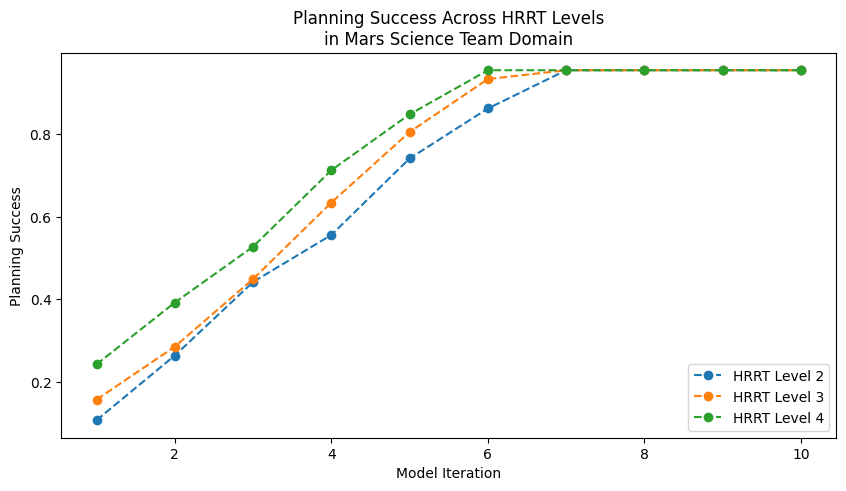

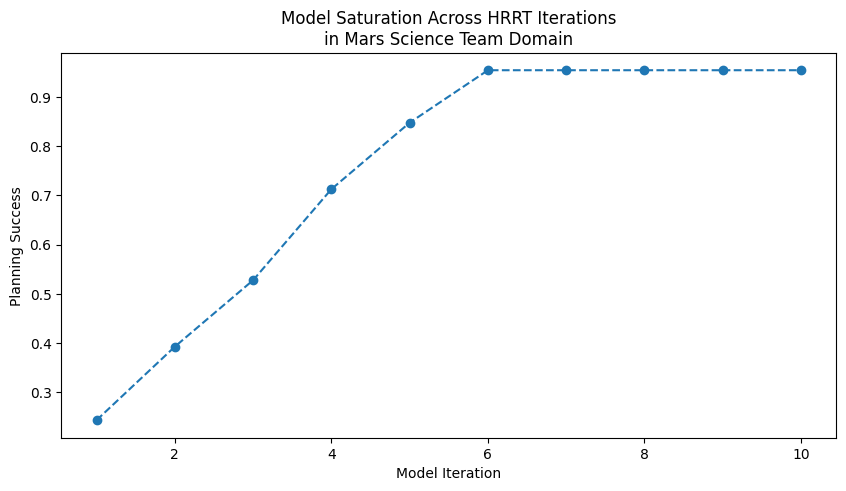

In [66]:
import numpy as np
import matplotlib.pyplot as plt

model_iterations = [i+1 for i in range(10)]
level_iterations = [i for i in range(2,5)]
labels = ['Model ' + str(i) for i in model_iterations]
level_labels = ['HRRT Level ' + str(l) for l in level_iterations]
model_iterations = np.array(model_iterations)
colors = [
    'tab:blue',
    'tab:red',
    'tab:purple',
    'tab:gray',
    'tab:cyan',
    'tab:brown',
    'tab:green',
    'tab:orange',
    'tab:pink',
    'tab:olive'
]

fig = plt.figure()
fig = plt.gcf()
fig.set_size_inches(10, 5)

lidx = 0
for level in level_model_success_rates_scaled.keys():
    level_model_success_rates_scaled[level] = np.array(level_model_success_rates_scaled[level])
    plt.plot(model_iterations, level_model_success_rates_scaled[level], 'o--', label=level_labels[lidx])
    lidx += 1
plt.legend(loc='lower right')
plt.title('Planning Success Across HRRT Levels\nin Mars Science Team Domain')
plt.xlabel('Model Iteration')
plt.ylabel('Planning Success')
plt.savefig("ablation_study_experiments.png")
plt.show()



fig = plt.figure()
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.plot(model_iterations, level_model_success_rates_scaled[4], 'o--')
plt.title('Model Saturation Across HRRT Iterations\nin Mars Science Team Domain')
plt.xlabel('Model Iteration')
plt.ylabel('Planning Success')
plt.savefig("saturation_experiments.png")
plt.show()